#### This code was adapted from this [Kaggle Tutorial](https://www.kaggle.com/code/kingabzpro/fine-tune-llama-3-1-for-text-classification)

The modifications were made in relation to:

- The prompt used in the generate_prompt and generate_prompt_test 
- Modification of the predict function to split on Relation
- Modification of the predict and evaluate functions with regards to the categories used
- Modification of the max steps to set to 2500 rather than -1 as we were training on cloud instance with per hour pay
- Added a section for loading the pretrained model and evaluating it

In [42]:
%%capture
%pip install matplotlib
%pip install -U bitsandbytes
%pip install -U transformers
%pip install -U accelerate
%pip install -U peft
%pip install -U trl
%pip install wandb
%pip install huggingface_hub
%pip install numpy
%pip install tqdm
%pip install pandas scikit-learn transformers sacremoses
%pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

In [43]:
import wandb
from huggingface_hub import login


wandb.login(key="<YOUR TOKEN>")
login(token="<YOUR_TOKEN>")

run = wandb.init(
    project='Fine-tune-llama3-8b', 
    job_type="training", 
    anonymous="allow"
)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [44]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from trl import setup_chat_format
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

## Loading and processing the dataset

In [45]:
df = pd.read_csv("arguments_dataset_cleaned.csv")[["Argument1","Argument2","Relation"]]
df.head()

,Argument1,Argument2,Relation
0,deductions exemptions eliminated us system inc...,stipend model instead standard deduction provi...,Support
1,stipend model instead standard deduction provi...,citizens dont make enough support would enough...,Support
2,citizens dont make enough support would enough...,homelessness would longer issue homeless encam...,Support
3,stipend model instead standard deduction provi...,stipend system would help people wish seek par...,Support
4,stipend model instead standard deduction provi...,stipend system would support lowest end income...,Support


In [46]:
# Shuffle the DataFrame and select only 3000 rows
df = df.sample(frac=1, random_state=85).reset_index(drop=True)

# Split the DataFrame
train_size = 0.9
eval_size = 0.075

# Calculate sizes
train_end = int(train_size * len(df))
eval_end = train_end + int(eval_size * len(df))

# Split the data
X_train = df[:train_end]
X_eval = df[train_end:eval_end]
X_test = df[eval_end:]

# Define the prompt generation functions
def generate_prompt(data_point):
    return f"""
            Does Argument 2 Attack or Support Argument 1? You cannot cannot provide any answer besides "Attack" or "Support". If you don't see any fit then simply strive to give the most accurate evaluation possible between "Attack" and "Support".
            Remember your answer must be only one of two words: "Attack" or "Support"
Argument 1: {data_point["Argument1"]}
Argument 2: {data_point["Argument2"]}
Relation: {data_point["Relation"]}""".strip()

def generate_test_prompt(data_point):
    return f"""
            Does Argument 2 Attack or Support Argument 1? You cannot cannot provide any answer besides "Attack" or "Support". If you don't see any fit then simply strive to give the most accurate evaluation possible between "Attack" and "Support".
            Remember your answer must be only one of two words: "Attack" or "Support"
Argument 1: {data_point["Argument1"]}
Argument 2: {data_point["Argument2"]}
Relation: """.strip()


X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)

# Generate test prompts and extract true labels
y_true = X_test.loc[:,'Relation']
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

/tmp/ipykernel_2444/2865684234.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.loc[:,'text'] = X_train.apply(generate_prompt, axis=1)
/tmp/ipykernel_2444/2865684234.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_eval.loc[:,'text'] = X_eval.apply(generate_prompt, axis=1)


In [47]:
X_train.Relation.value_counts()

Relation
Attack     26435
Support    24844
Name: count, dtype: int64

In [48]:
y_true.value_counts()

Relation
Support    728
Attack     697
Name: count, dtype: int64

In [49]:
# Convert to datasets
train_data = Dataset.from_pandas(X_train[["text"]])
eval_data = Dataset.from_pandas(X_eval[["text"]])

In [50]:
train_data['text'][3]

'Does Argument 2 Attack or Support Argument 1? You cannot cannot provide any answer besides "Attack" or "Support". If you don\'t see any fit then simply strive to give the most accurate evaluation possible between "Attack" and "Support".\n            Remember you answer must be only one of two words: "Attack" or "Support"\nArgument 1: speculate difficult differentiate human agi cognition achieve technological singularity point time advancement technology results creation artificial intelligence superior human intelligence\nArgument 2: given difficulty differentiating agi human beings singularity achieved necessary grant agi fundamental rights order protect fundamental rights human beings\nRelation: Support'

## Loading the model and tokenizer

In [51]:
base_model_name = "meta-llama/Llama-3.1-8B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    base_model_name,
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config, 
)

model.config.use_cache = False
model.config.pretraining_tp = 1

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [52]:
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

tokenizer.pad_token_id = tokenizer.eos_token_id

## Model evalution before fine-tuning

In [53]:
def predict(test, model, tokenizer):
    y_pred = []
    categories = ["Attack", "Support"]
    
    for i in tqdm(range(len(test))):
        prompt = test.iloc[i]["text"]
        pipe = pipeline(task="text-generation", 
                        model=model, 
                        tokenizer=tokenizer, 
                        max_new_tokens=2, 
                        temperature=0.1)
        
        result = pipe(prompt)
        answer = result[0]['generated_text'].split("Relation:")[-1].strip()
        
        for category in categories:
            if category.lower() in answer.lower():
                y_pred.append(category)
                break
        else:
            y_pred.append("none")   
    return y_pred

In [54]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 1425/1425 [02:52<00:00,  8.26it/s]


In [55]:
def evaluate(y_true, y_pred):
    labels = ["Attack", "Support"]
    mapping = {label: idx for idx, label in enumerate(labels)}
    
    def map_func(x):
        return mapping.get(x, -1)
    
    y_true_mapped = np.vectorize(map_func)(y_true)
    y_pred_mapped = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true_mapped, y_pred=y_pred_mapped)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true_mapped)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true_mapped)) if y_true_mapped[i] == label]
        label_y_true = [y_true_mapped[i] for i in label_indices]
        label_y_pred = [y_pred_mapped[i] for i in label_indices]
        label_accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {labels[label]}: {label_accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true_mapped, y_pred=y_pred_mapped, target_names=labels, labels=list(range(len(labels))))
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=list(range(len(labels))))
    print('\nConfusion Matrix:')
    print(conf_matrix)

In [56]:
evaluate(y_true, y_pred)

Accuracy: 0.127
Accuracy for label Attack: 0.230
Accuracy for label Support: 0.029

Classification Report:
              precision    recall  f1-score   support

      Attack       0.56      0.23      0.33       697
     Support       0.84      0.03      0.06       728

   micro avg       0.58      0.13      0.21      1425
   macro avg       0.70      0.13      0.19      1425
weighted avg       0.70      0.13      0.19      1425


Confusion Matrix:
[[160   4]
 [127  21]]


## Extracting the linear modules names

In [16]:
import bitsandbytes as bnb

def find_all_linear_names(model):
    cls = bnb.nn.Linear4bit
    lora_module_names = set()
    for name, module in model.named_modules():
        if isinstance(module, cls):
            names = name.split('.')
            lora_module_names.add(names[0] if len(names) == 1 else names[-1])
    if 'lm_head' in lora_module_names:
        lora_module_names.remove('lm_head')
    return list(lora_module_names)

In [17]:
modules = find_all_linear_names(model)
modules

['k_proj', 'q_proj', 'gate_proj', 'o_proj', 'up_proj', 'down_proj', 'v_proj']

## Setting up the model

In [22]:
output_dir="llama-3.1-fine-tuned-model"

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=modules,
)

training_arguments = TrainingArguments(
    output_dir=output_dir,                    # directory to save and repository id
    num_train_epochs=1,                       # number of training epochs
    per_device_train_batch_size=1,            # batch size per device during training
    gradient_accumulation_steps=8,            # number of steps before performing a backward/update pass
    gradient_checkpointing=True,              # use gradient checkpointing to save memory
    optim="paged_adamw_32bit",
    logging_steps=1,                         
    learning_rate=2e-4,                       # learning rate, based on QLoRA paper
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,                        # max gradient norm based on QLoRA paper
    max_steps=2500,
    warmup_ratio=0.03,                        # warmup ratio based on QLoRA paper
    group_by_length=False,
    lr_scheduler_type="cosine",               # use cosine learning rate scheduler
    report_to="wandb",                  # report metrics to w&b
    eval_strategy="steps",              # save checkpoint every epoch
    eval_steps = 0.2
)

trainer = SFTTrainer(
    model=model,
    args=training_arguments,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=512,
    packing=False,
    dataset_kwargs={
    "add_special_tokens": False,
    "append_concat_token": False,
    }
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:100: FutureWarning: Deprecated argument(s) used in '__init__': dataset_text_field, max_seq_length, dataset_kwargs. Will not be supported from version '1.0.0'.

Deprecated positional argument(s) used in SFTTrainer, please use the SFTConfig to set these arguments instead.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:283: UserWarning: You passed a `max_seq_length` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:321: UserWarning: You passed a `dataset_text_field` argument to the SFTTrainer, the value you passed will override the one in the `SFTConfig`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/trl/trainer/sft_trainer.py:327: UserWarning: You passed a `dataset_kwargs` argument to the SFTTrainer, the value you pass

Map:   0%|          | 0/51279 [00:00<?, ? examples/s]

Map:   0%|          | 0/4273 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


## Model Training

In [23]:
# Train model
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss
500,1.225300,1.316883
1000,1.330200,1.277158
1500,1.211500,1.245552
2000,1.254100,1.225897
2500,1.333700,1.221467


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.

TrainOutput(global_step=2500, training_loss=1.2590059324741363, metrics={'train_runtime': 8224.9083, 'train_samples_per_second': 2.432, 'train_steps_per_second': 0.304, 'total_flos': 1.0351253710523597e+17, 'train_loss': 1.2590059324741363, 'epoch': 0.39002320638077964})

In [24]:
wandb.finish()
model.config.use_cache = True

eval/loss,█▅▃▁▁
eval/runtime,█▃▇▂▁
eval/samples_per_second,▁▆▂▇█
eval/steps_per_second,▁▅▂▇█
train/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train/global_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇█
train/grad_norm,█▁▁▂▁▁▁▁▂▁▁▂▁▁▂▂▁▁▁▂▂▂▂▁▁▂▁▂▁▁▁▁▂▁▂▁▂▁▂▂
train/learning_rate,▁▃████▇▇▇▇▇▇▇▇▇▆▆▆▆▅▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train/loss,██▂▂▁▂▁▁▂▂▁▃▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▂▂▂▁▁▁▂▁▂▁▂
eval/loss,1.22147
eval/runtime,110.7634


## Saving the model and tokenizer

In [25]:
# Save trained model and tokenizer
trainer.save_model(output_dir)
tokenizer.save_pretrained(output_dir)

('llama-3.1-fine-tuned-model/tokenizer_config.json',
 'llama-3.1-fine-tuned-model/special_tokens_map.json',
 'llama-3.1-fine-tuned-model/tokenizer.json')

## Testing model after fine-tuning 

In [57]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf8",
    bnb_4bit_compute_dtype="float16",
)

model = AutoModelForCausalLM.from_pretrained(
    "llama3-fine-tuned-model",
    device_map="auto",
    torch_dtype="float16",
    quantization_config=bnb_config, 
)

tokenizer = AutoTokenizer.from_pretrained("llama3-fine-tuned-model")
tokenizer.pad_token_id = tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [59]:
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 1425/1425 [04:39<00:00,  5.11it/s]


Accuracy: 0.808
Accuracy for label Attack: 0.822
Accuracy for label Support: 0.795

Classification Report:
              precision    recall  f1-score   support

      Attack       0.79      0.82      0.81       697
     Support       0.82      0.80      0.81       728

    accuracy                           0.81      1425
   macro avg       0.81      0.81      0.81      1425
weighted avg       0.81      0.81      0.81      1425


Confusion Matrix:
[[573 124]
 [149 579]]


Accuracy: 0.8084210526315789


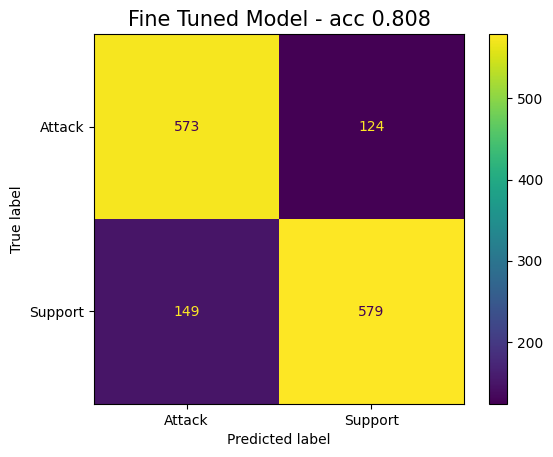

In [63]:
accuracy = accuracy_score(y_true,y_pred)
print(f"Accuracy: {accuracy}")
ConfusionMatrixDisplay.from_predictions(y_true,y_pred)
plt.title(f'Fine Tuned Model - acc {accuracy:.3f}', size=15)
plt.show()

In [64]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

      Attack       0.79      0.82      0.81       697
     Support       0.82      0.80      0.81       728

    accuracy                           0.81      1425
   macro avg       0.81      0.81      0.81      1425
weighted avg       0.81      0.81      0.81      1425

